In [1]:
# The majority of the code in this file was AI Generated: ChatGPT-5, 11/25/25

# Import the created modules and set device
import sys
sys.path.append("..")

from src.data import *
from src.model import *
from src.train import *
from src.evaluate import *
from src.inference import *

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

c:\Users\User\.conda\envs\env_cs372\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
# Load dataset and build DataFrames (may download from Hugging Face)
dataset = load_hf_dataset()
df_train, df_val, df_test = build_records(dataset)
print('Train samples:', len(df_train), 'Val samples:', len(df_val), 'Test samples:', len(df_test))

Extracting meals: 100%|██████████| 263/263 [00:01<00:00, 144.51it/s]

Train samples: 921 Val samples: 132 Test samples: 263


In [3]:
# Build label map (top 400) and encode label vectors
label_map, inv_label_map = build_label_map(df_train)
df_train = encode_df(df_train, label_map)
df_val   = encode_df(df_val, label_map)
df_test  = encode_df(df_test, label_map)
print('Sample encoded label vector length:', len(df_train['label_vec'].iloc[0]))

Sample encoded label vector length: 400


In [4]:
# Create datasets and dataloaders
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_dataloaders(df_train, df_val, df_test)
print('Train loader batches:', len(train_loader))

Train loader batches: 29


In [5]:
# Build and train baseline TinyCNN (quick run)
num_classes = len(label_map)
model_baseline = build_baseline_model(num_classes)
train_baseline_model(model_baseline, train_loader, df_train, device, epochs=5, lr=1e-3, save_path='../models/baseline_weights.pt')
print('Baseline training finished.')

Epoch 1 | Train Loss: 2.0073
Epoch 2 | Train Loss: 1.3528
Epoch 3 | Train Loss: 1.3503
Epoch 4 | Train Loss: 1.3535
Epoch 5 | Train Loss: 1.3523
Baseline model saved to ../models/baseline_weights.pt
Baseline training finished.


In [6]:
# Evaluate baseline model
scores_baseline = evaluate(model_baseline, val_loader, device)
print('Baseline scores:', scores_baseline)

Baseline scores: (0.060725671777744045, 0.02600721324385409)


In [7]:
# Build and fine-tune ResNet 
model_resnet = build_resnet_model(num_classes)
train_resnet_model(model_resnet, train_loader, df_train, device, epochs=3, lr=1e-4, save_path='../models/resnet_finetuned_weights.pt')
print('ResNet head fine-tuning finished.')

Epoch 1/3 - Loss: 1.3944
Epoch 2/3 - Loss: 1.3539
Epoch 3/3 - Loss: 1.3461
Resnet model saved to ../models/resnet_finetuned_weights.pt
ResNet head fine-tuning finished.


In [8]:
# Evaluate ResNet
scores_resnet = evaluate(model_resnet, val_loader, device)
print('ResNet scores:', scores_resnet)

ResNet scores: (0.11842617841838722, 0.038446278671360926)


In [9]:
pipe = load_text_generator(model_name='microsoft/phi-2')  

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0


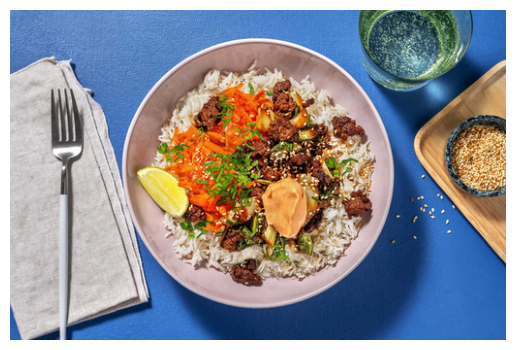

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


KeyboardInterrupt: 

In [10]:
# Example: run full pipeline on one sample (may require internet and GPU for LLM)
from PIL import Image
import matplotlib.pyplot as plt

sample = df_val.iloc[5]
pil_img = sample['image']
dish_name = sample.get("dish", None) 
plt.imshow(pil_img)
plt.axis("off")
plt.show()
ingredients, recipe = generate_recipe_from_image(pil_img, dish_name, model_resnet, val_ds.transform, inv_label_map, device, pipe, threshold=0.5)
print('Predicted ingredients:', ingredients)
print('\nGenerated recipe (truncated):\n', recipe[:1000])